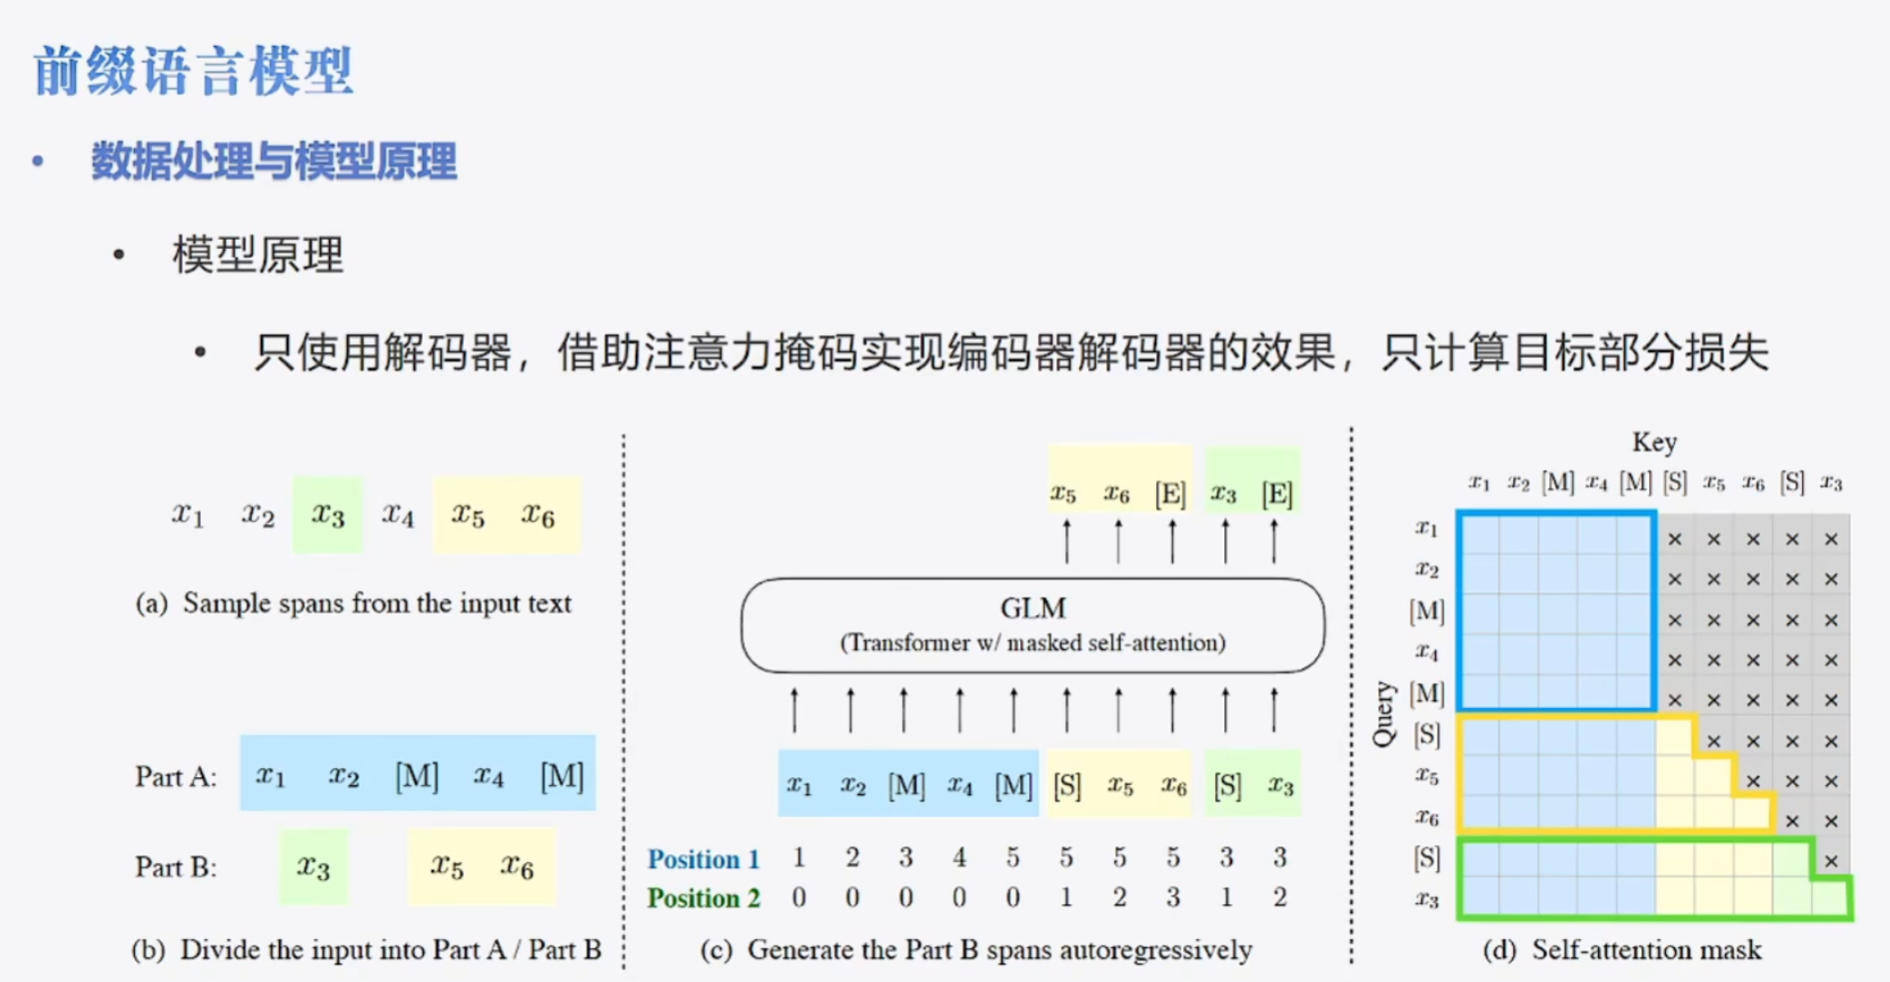

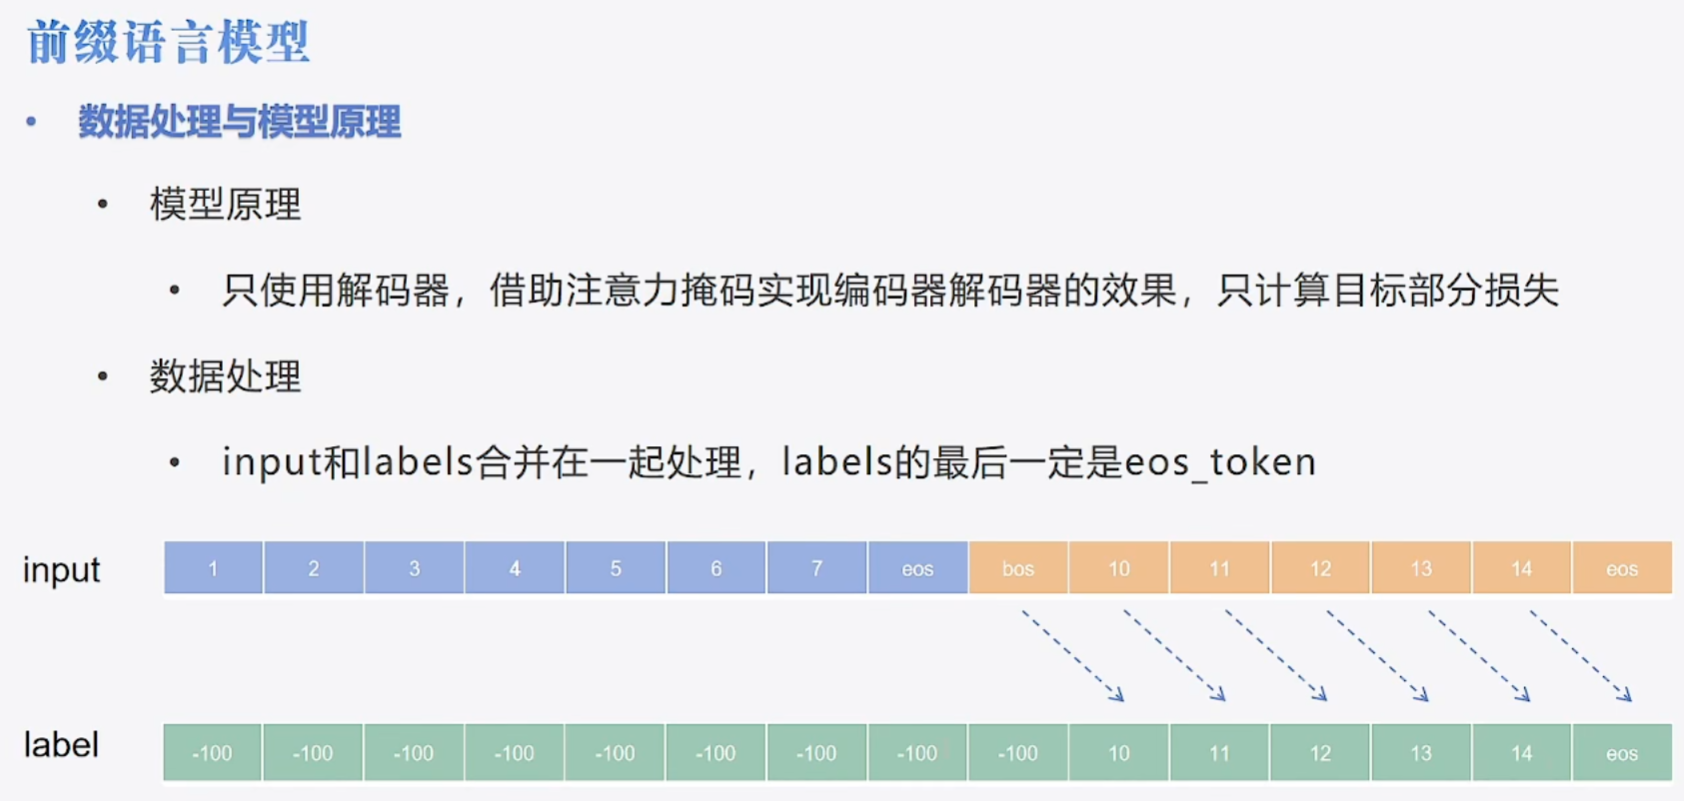

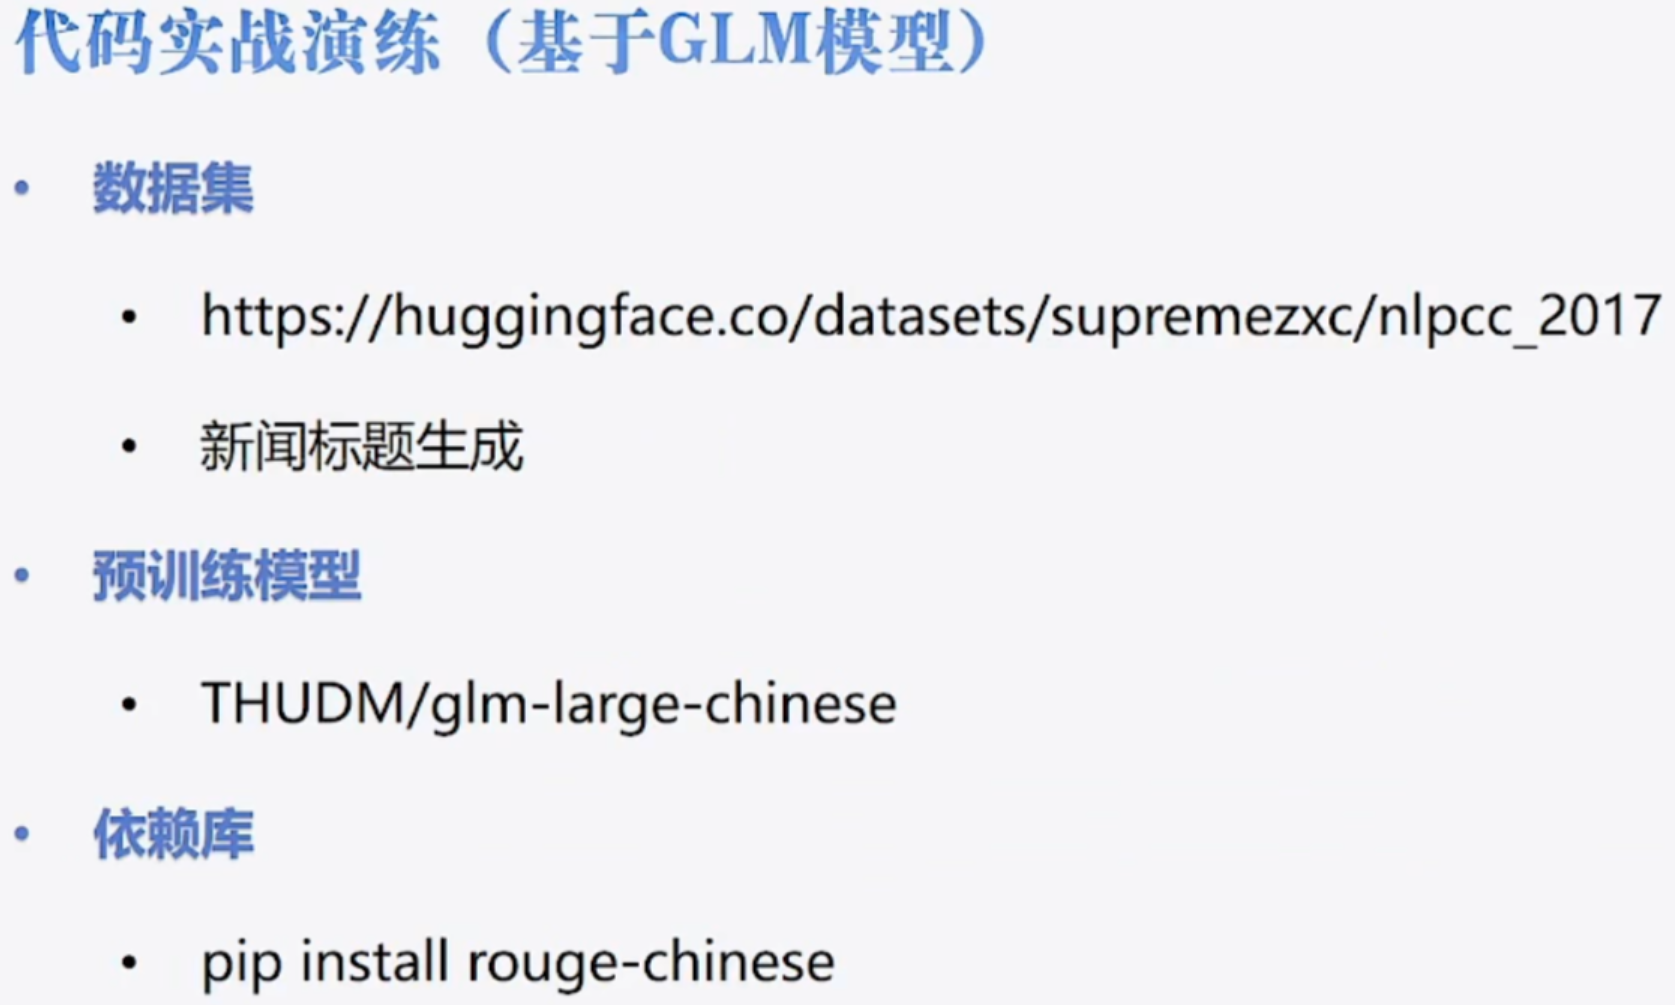

## Step1 导入包

In [1]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM,DataCollatorForSeq2Seq,Seq2SeqTrainer,Seq2SeqTrainingArguments

## Step2 加载数据集

In [2]:
ds=Dataset.load_from_disk("./nlpcc_2017/")
ds

Dataset({
    features: ['title', 'content'],
    num_rows: 5000
})

In [3]:
ds=ds.train_test_split(100,seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'content'],
        num_rows: 4900
    })
    test: Dataset({
        features: ['title', 'content'],
        num_rows: 100
    })
})

In [4]:
ds['train'][0]

{'title': '组图:黑河边防军人零下30℃户外训练,冰霜沾满眉毛和睫毛,防寒服上满是冰霜。',
 'content': '中国军网2014-12-1709:08:0412月16日,黑龙江省军区驻黑河某边防团机动步兵连官兵,冒着-30℃严寒气温进行体能训练,挑战极寒,锻造钢筋铁骨。该连素有“世界冠军的摇篮”之称,曾有5人24人次登上世界军事五项冠军的领奖台。(魏建顺摄)黑龙江省军区驻黑河某边防团机动步兵连官兵冒着-30℃严寒气温进行体能训练驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜官兵睫毛上都被冻上了冰霜官兵们睫毛上都被冻上了冰霜驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练'}

## Step3 数据预处理

In [5]:
tokenzier = AutoTokenizer.from_pretrained("THUDM/glm-large-chinese", trust_remote_code=True,force_download=True)
tokenzier

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenization_glm.py: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

cog-pretrain.model:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/223 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GLMChineseTokenizer(name_or_path='THUDM/glm-large-chinese', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='left', special_tokens={'eos_token': '<|endoftext|>', 'unk_token': '[UNK]', 'pad_token': '<|endoftext|>', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['<|startofpiece|>', '<|endofpiece|>', '[gMASK]', '[sMASK]']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50001: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50002: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50003: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("[UNUSED1]", rstrip=False, lstrip=False, single_word=Fa

In [6]:
def process_func(examples):
    contents=["摘要生成:\n"+e for e in examples['content']]
    inputs=tokenzier(contents,padding='max_length',truncation=True,max_length=384,return_tensors='pt')
    inputs=tokenzier.build_inputs_for_generation(inputs,targets=examples['title'],padding=True,max_gen_length=64)#自己实现的一个类
    
    return inputs

In [7]:
tokenizer_ds=ds.map(process_func,batched=True,remove_columns=ds['train'].column_names)
tokenizer_ds

Map:   0%|          | 0/4900 [00:00<?, ? examples/s]

ValueError: Cannot find mask token in the input

In [8]:
tokenizer.decode(tokenizer_ds["train"][0]["input_ids"])

'摘要生成: 中国军网2014-12-1709:08:0412月16日,黑龙江省军区驻黑河某边防团机动步兵连官兵,冒着-30°C严寒气温进行体能训练,挑战极寒,锻造钢筋铁骨。该连素有“世界冠军的摇篮”之称,曾有5人24人次登上世界军事五项冠军的领奖台。(魏建顺摄)黑龙江省军区驻黑河某边防团机动步兵连官兵冒着-30°C严寒气温进行体能训练驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜驻黑河某边防团机动步兵连官兵严寒中户外训练,防寒服上满是冰霜官兵睫毛上都被冻上了冰霜官兵们睫毛上都被冻上了冰霜驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练驻黑河某边防团机动步兵连官兵严寒中进行户外体能训练</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [9]:
tokenizer.decode(tokenizer_ds["train"][0]["labels"])

'组图:黑河边防军人零下30°C户外训练,冰霜沾满眉毛和睫毛,防寒服上满是冰霜。</s>'

## Step4 创建模型

In [10]:
model=AutoModelForSeq2SeqLM.from_pretrained("Langboat/mengzi-t5-base")

## Step5 创建评估函数

In [11]:
import numpy as np
from rouge_chinese import Rouge

rouge=Rouge()
def compute_metrics(eval_pred):
    predictions,labels=eval_pred
    decode_preds=tokenizer.batch_decode(predictions,skip_special_tokens=True)
    laebls=np.where(labels!=-100,labels,tokenizer.pad_token_id)
    decode_labels=tokenizer.batch_decode(laebls,skip_special_tokens=True)
    # 基于字来做处理，将里面数据用空格连接
    decode_preds=[' '.join(pred) for pred in decode_preds]
    decode_labels=[' '.join(label) for label in decode_labels]
    score=rouge.get_scores(hyps=decode_preds,refs=decode_labels,avg=True)
    return {
        'rouge-1':score['rouge-1']['f'],
        'rouge-2':score['rouge-2']['f'],
        'rouge-l':score['rouge-l']['f']
    }



## Step6 配置训练参数

In [12]:
args=Seq2SeqTrainingArguments(
    output_dir="./summary",             # 模型保存路径
    per_device_train_batch_size=4,      # 每块GPU的训练批次大小
    per_device_eval_batch_size=8,        # 每块GPU的评估批次大小
    gradient_accumulation_steps=8,      # 梯度累积步数，默认为1
    logging_steps=8,                    # 每训练多少步打印一次日志
    eval_strategy="epoch",              # 评估策略，默认为"no"，可选值有["no", "steps", "epoch"]
    save_strategy="epoch",              # 保存策略，默认为"steps"，可选值有["no", "steps", "epoch"]
    metric_for_best_model="rouge-l",    # 最佳模型保存的指标，默认为"loss"
    predict_with_generate=True,         # 评估的时候是否使用生成器生成预测结果，默认为True
    # load_best_model_at_end=True,
    
)


## Step7 创建训练器

In [13]:
trainer=Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenizer_ds["train"],
    eval_dataset=tokenizer_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)

## Step8 训练模型

In [ ]:
trainer.train()

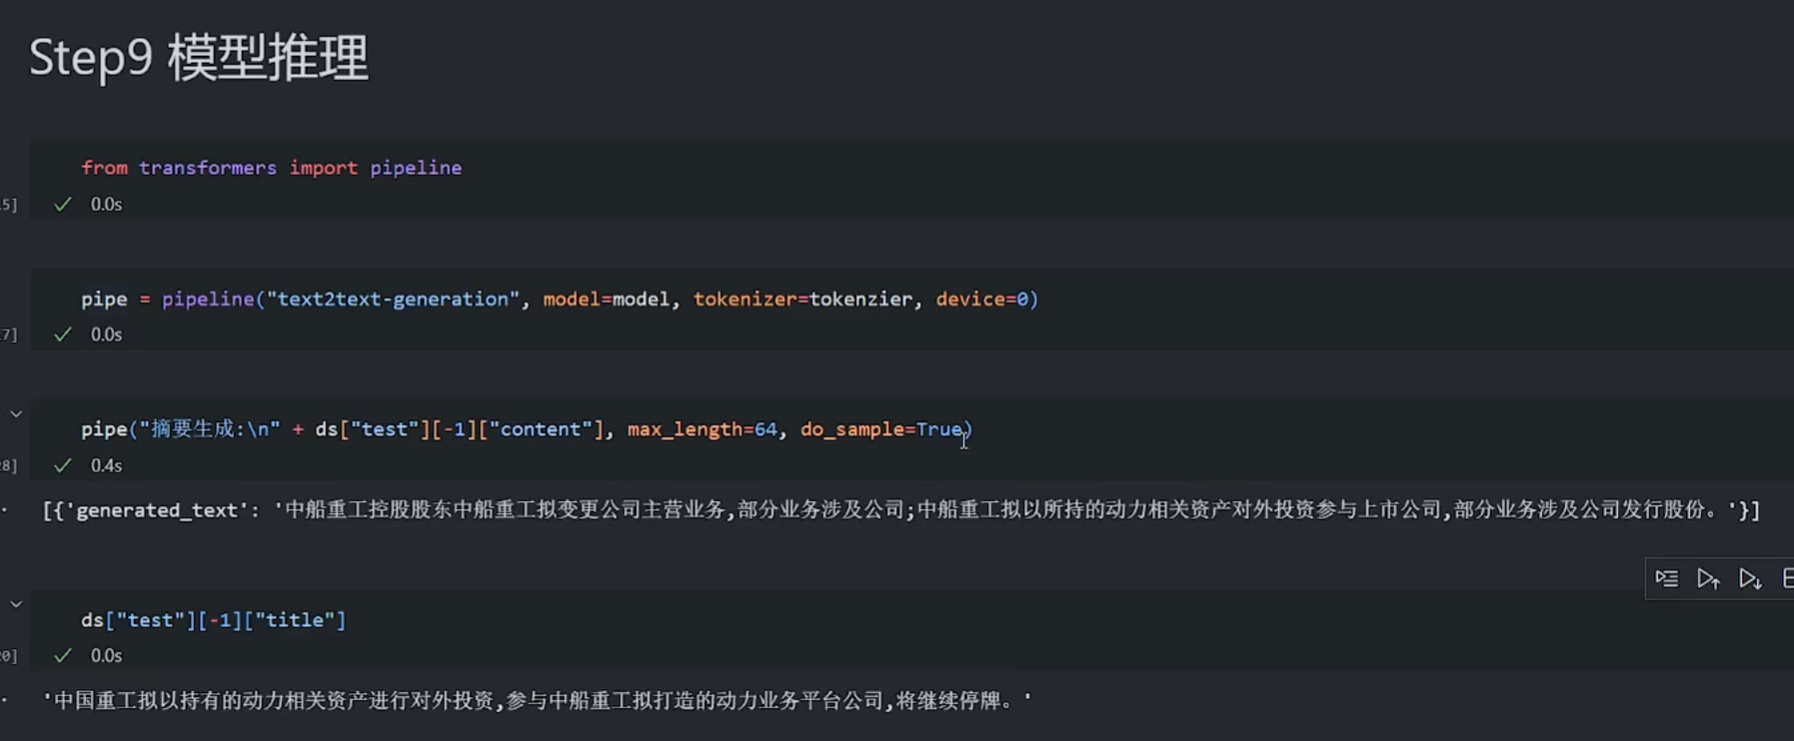